In [1]:
import numpy as np
import pandas as pd
import xgboost
import yaml
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from sklearn.model_selection import StratifiedKFold


class generate_model:
    def __init__(
        self,
        predictor_col: str,
        data_path: str,
        xg_params: dict,
        kfold_splits: int,
        test_size=0.3,
        removed_features: list[str] = None,
        seed: float = None,
    ) -> None:
        if removed_features is None:
            removed_features = []
        dataset = pd.read_csv(data_path)

        # Variable encoding
        dataset["Género"] = (
            dataset["Género"].replace({"M": 0, "F": 1}).astype("category")
        )
        dataset["ATPII/AHA/IDF"] = (
            dataset["ATPII/AHA/IDF"].replace({"no": 0, "si": 1}).astype("category")
        )
        dataset["aleator"] = (
            dataset["aleator"]
            .replace({"Control": 0, "PKU 1": 1, "PKU 2": 2})
            .astype("category")
        )

        y_df = dataset[predictor_col].replace({"No": 0, "Si": 1}).astype("category")
        X_df = dataset.drop(predictor_col, axis="columns")

        X_df = X_df.drop(removed_features, axis="columns")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_df, y_df, stratify=y_df, test_size=test_size, random_state=seed
        )
        # def xg_train(self, xg_params: dict, kfold_splits=5, seed=None):

        cv = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=seed)
        folds = list(cv.split(self.X_train, self.y_train))

        for train_idx, val_idx in folds:
            # Sub-empaquetado del train-set en formato de XGBoost
            dtrain = xgboost.DMatrix(
                self.X_train.iloc[train_idx, :],
                label=self.y_train.iloc[train_idx],
                enable_categorical=True,
            )
            dval = xgboost.DMatrix(
                self.X_train.iloc[val_idx, :],
                label=self.y_train.iloc[val_idx],
                enable_categorical=True,
            )

            self.model = xgboost.train(
                dtrain=dtrain,
                params=xg_params,
                evals=[(dtrain, "train"), (dval, "val")],
                num_boost_round=1000,
                verbose_eval=False,
                early_stopping_rounds=10,
            )

    def get_AUC_on_test_data(self):
        # def xg_test(model, X_test, y_test) -> float:
        testset = xgboost.DMatrix(
            self.X_test, label=self.y_test, enable_categorical=True
        )
        y_preds = self.model.predict(testset)

        return roc_auc_score(testset.get_label(), y_preds)

    def get_feature_metrics(self):
        internal_feature_metrics = pd.DataFrame(
            {
                "Weight": self.model.get_score(importance_type="weight"),
                "Coverage": self.model.get_score(importance_type="cover"),
                "Gain": self.model.get_score(importance_type="gain"),
            }
        ).sort_values(by="Gain", ascending=False)

        explainer = shap.TreeExplainer(self.model)

        # Extrae la explicacion SHAP en un DF
        EXPLAINATION = explainer(self.X_test).cohorts(
            self.y_test.replace({0: "Healty", 1: "Abnormal"}).tolist()
        )
        cohort_exps = list(EXPLAINATION.cohorts.values())

        exp_shap_abnormal = pd.DataFrame(
            cohort_exps[0].values, columns=cohort_exps[0].feature_names
        )  # .abs().mean()

        exp_shap_healty = pd.DataFrame(
            cohort_exps[1].values, columns=cohort_exps[1].feature_names
        )  # .abs().mean()

        feature_metrics = pd.concat(
            {
                "SHAP_healty": exp_shap_healty.abs().mean(),
                "SHAP_abnormal": exp_shap_abnormal.abs().mean(),
            },
            axis="columns",
        )

        feature_metrics = (
            feature_metrics.join(internal_feature_metrics)
            .fillna(0)
            .sort_values(by="Gain", ascending=False)
        )

        return feature_metrics

    def get_explainer_SHAP(self):
        explainer = shap.TreeExplainer(self.model)

        # Extrae la explicacion SHAP en un DF
        explainer_fitted = explainer(self.X_test)

        cohorts = explainer_fitted.cohorts(
            self.y_test.replace({0: "Healty", 1: "Abnormal"}).tolist()
        )

        return explainer, explainer_fitted, cohorts


with open("params.yml", "r") as f:
    ext_params = yaml.load(f, Loader=yaml.FullLoader)


def objective(trial) -> float:
    """
    The function that runs a single model and evaluates it.
    """
    params = {
        "seed": trial.suggest_int("seed", 1, 10_000),
        # "kfold_splits": trial.suggest_int("kfold_splits", 3, 5),
        # XGB_hiperparams
        # "max_depth": trial.suggest_int("max_depth", 2, 10),
        # "eta": trial.suggest_float("eta", 0.01, 0.3),
        # "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "objective": "binary:logistic",
        "eval_metric": "logloss",
    }

    model_instance = generate_model(
        "HOMA-IR alterado",
        "data/data.csv",
        removed_features=ext_params["feature_engineering"]["removed_features"],
        xg_params=params,
        kfold_splits=5,
        seed=params["seed"],
    )

    return (
        model_instance.get_AUC_on_test_data(),
        model_instance.get_feature_metrics()["SHAP_abnormal"]["fenilalax"],
    )


In [2]:
%%time

import optuna
study_name: str = "no-name-74ad8142-79aa-4458-a875-7173de149487"

study = optuna.create_study(
    study_name=study_name,
    storage="sqlite:///homa_studies.db",
    directions=["maximize", "maximize"],
    sampler=optuna.samplers.NSGAIISampler(),
    load_if_exists=True,
)

study.optimize(objective, n_trials=1, n_jobs=-1)


[I 2023-04-27 16:14:22,297] Using an existing study with name 'no-name-74ad8142-79aa-4458-a875-7173de149487' instead of creating a new one.
[I 2023-04-27 16:14:25,362] Trial 9000 finished with values: [0.5833333333333334, 0.0] and parameters: {'seed': 5047}. 


CPU times: user 17.8 s, sys: 159 ms, total: 18 s
Wall time: 3.46 s


In [3]:
import pandas as pd
from optuna.visualization._pareto_front import (
    _get_pareto_front_info,
    _make_scatter_object,
    _make_marker,
    _make_hovertext,
)
from typing import Sequence
from optuna.trial import FrozenTrial
from optuna.visualization._plotly_imports import go


info = _get_pareto_front_info(study)


n_targets: int = info.n_targets
axis_order: Sequence[int] = info.axis_order
include_dominated_trials: bool = True
trials_with_values: Sequence[
    tuple[FrozenTrial, Sequence[float]]
] = info.non_best_trials_with_values
hovertemplate: str = "%{text}<extra>Trial</extra>"
infeasible: bool = False
dominated_trials: bool = False


def trials_df(trials_with_values, class_name):
    x = [values[axis_order[0]] for _, values in trials_with_values]
    y = [values[axis_order[1]] for _, values in trials_with_values]

    df = pd.DataFrame({"x": x, "y": y})
    df["class"] = class_name
    return df


df_best = trials_df(info.best_trials_with_values, "best")
df_nonbest = trials_df(info.non_best_trials_with_values, "nonbest")
# df         = pd.concat([df_best, df_nonbest])

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_nonbest["x"],
        y=df_nonbest["y"],
        mode="markers",
        marker=dict(
            size=8, opacity=0.5, symbol="circle", line=dict(width=1, color="black")
        ),
        name="Suboptimal",
    )
)
fig.add_trace(
    go.Scatter(
        x=df_best["x"],
        y=df_best["y"],
        mode="markers",
        marker=dict(
            size=8, opacity=0.5, symbol="square", line=dict(width=1, color="black")
        ),
        name="Pareto frontier",
    )
)
# Define the width and height of the plot
plot_width = 800
plot_height = 400

# Customize the plot
fig.update_layout(
    # title='Two-objective optimization',
    xaxis_title="AUC",
    yaxis_title="Phe importance",
    font=dict(size=14),
    # plot_bgcolor='white',
    # xaxis=dict(range=[min(df['x']) - 1, max(df['x']) + 1]),
    # yaxis=dict(range=[min(df['y']) - 1, max(df['y']) + 1]),
    legend=dict(x=0.3, y=1.1, bgcolor="rgba(255, 255, 255, 0)", orientation="h"),
    width=plot_width,
    height=plot_height,
    margin=dict(l=0, r=0, t=0, b=0),
)

# Show the plot
fig.show()


In [4]:
# Extract the best trials from the multi-objective study
best_trials = study.best_trials

# Print information about the best trials
for i, trial in enumerate(best_trials):
    print(f"Best trial {i+1} number: {trial.number}")
    print(f"Best trial {i+1} values: {trial.values}")
    print(f"Best trial {i+1} parameters: {trial.params}")
    print()


Best trial 1 number: 445
Best trial 1 values: [0.8333333333333334, 0.6549437046051025]
Best trial 1 parameters: {'seed': 5708}

Best trial 2 number: 1965
Best trial 2 values: [0.8055555555555556, 0.6763508915901184]
Best trial 2 parameters: {'seed': 8684}

Best trial 3 number: 2129
Best trial 3 values: [0.9722222222222222, 0.3059413433074951]
Best trial 3 parameters: {'seed': 1993}

Best trial 4 number: 4435
Best trial 4 values: [0.8461538461538461, 0.5377874970436096]
Best trial 4 parameters: {'seed': 5268}

Best trial 5 number: 4717
Best trial 5 values: [0.8846153846153846, 0.530384361743927]
Best trial 5 parameters: {'seed': 3401}

Best trial 6 number: 5042
Best trial 6 values: [0.9615384615384616, 0.43251505494117737]
Best trial 6 parameters: {'seed': 8726}

Best trial 7 number: 5443
Best trial 7 values: [0.8055555555555556, 0.6763508915901184]
Best trial 7 parameters: {'seed': 8684}

Best trial 8 number: 5470
Best trial 8 values: [0.8333333333333334, 0.6549437046051025]
Best trial

In [5]:
bs_trials = pd.DataFrame(columns=["roc", "phe"])

for t in study.best_trials:
    bs_trials.loc[t.params["seed"]] = [t.values[0], t.values[1]]


,roc,phe
5708,0.833333,0.654944
8684,0.805556,0.676351
1993,0.972222,0.305941
5268,0.846154,0.537787
3401,0.884615,0.530384
8726,0.961538,0.432515
3594,1.000000,0.274718
5804,0.486111,0.798218
7139,0.638889,0.710454


In [22]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
}

paretos = {}

for seed in bs_trials.index: 

    model_instance = generate_model(
        "HOMA-IR alterado",
        "data/data.csv",
        removed_features=ext_params["feature_engineering"]["removed_features"],
        xg_params=params,
        kfold_splits=5,
        seed=seed,
    )

    paretos[f"pareto_{seed}"] = model_instance.get_feature_metrics()["SHAP_abnormal"]


,%_Proteina_SP,%_proteina_natural,3-OH-Isovalerilcarnitina,3-OH-Linoleoilcarnitina,3-OH-Palmitoilcarnitina,ATPII/AHA/IDF,Acetilcarnitina,Alanina,Arginina,Aspartato,...,Succinilacetona,Tetradecanoilcarnitina,Tetradecenoilcarnitina,Tiglilcarnitina,Tirosina,Valina,aleator,fenilalax,ohd3x,tirosinax
pareto_5708,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.091768,0.116685,0.0,0.654944,0.078299,0.000000
pareto_8684,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.364057,0.0,0.676351,0.084321,0.050363
pareto_1993,0.0,0.000000,0.0,0.0,0.0,0.0,0.571947,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.306069,0.153770,0.0,0.305941,0.000000,0.000000
pareto_5268,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.045747,0.000000,0.125200,0.0,0.537787,0.000000,0.000000
pareto_3401,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.294112,0.000000,0.000000,0.000000,0.0,0.530384,0.000000,0.000000
pareto_8726,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.295281,...,0.0,0.0,0.000000,0.000000,0.073866,0.116530,0.0,0.432515,0.344734,0.000000
pareto_3594,0.0,0.037366,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.132193,0.230670,0.0,0.274718,0.000000,0.000000
pareto_5804,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.798218,0.000000,0.000000
pareto_7139,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.710454,0.000000,0.000000


In [35]:
df_paretos.mean(axis="columns")

IMC                          0.712766
fenilalax                    0.546813
Estearoilcarnitina           0.140476
Valina                       0.122990
Glutarilcarnitina            0.034301
Tirosina                     0.067100
ohd3x                        0.056373
PROTEINAProm_(G)             0.089177
Leucina                      0.000000
Linoleoilcarnitina           0.148571
Me-Glutarilcarnitina         0.000000
Metionina                    0.054226
Octanoilcarnitina            0.014092
Ornitina                     0.073265
%_Proteina_SP                0.000000
Palmitoilcarnitina           0.045111
Isovalerilcarnitina          0.012084
Propionilcarnitina           0.004522
Succinilacetona              0.000000
Tetradecanoilcarnitina       0.000000
Tetradecenoilcarnitina       0.032679
Tiglilcarnitina              0.005083
aleator                      0.000000
Prolina                      0.051955
Hexanoilcarnitina            0.000000
%_proteina_natural           0.004152
Género      

In [33]:
df_paretos = pd.DataFrame(paretos).sort_values(by="pareto_5708", ascending=False)

import plotly.express as px

px.line(df_paretos)

In [19]:
feature_names = model_instance.get_feature_metrics()

pd.DataFrame( explainer_fitted.values, columns=feature_names)


,Linoleoilcarnitina,IMC,fenilalax,Circunferencia de cintura,Metionina,Género,Glutarilcarnitina,Citrulina,Glicina,Fenilalanina,...,Prolina,Tirosina,Carnitina libre,Propionilcarnitina,Isovalerilcarnitina,Tiglilcarnitina,Me-Glutarilcarnitina,Decanoilcarnitina,Tetradecanoilcarnitina,%_Proteina_SP
0,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.079107,0.152726,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-0.519462,-0.142291,0.0,1.346033,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-0.519462,-0.142291,0.0,1.346033,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.079107,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,-0.519462,-0.142291,0.0,-0.798218,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/DeepenData/.miniconda/envs/PKU-multilabeling/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



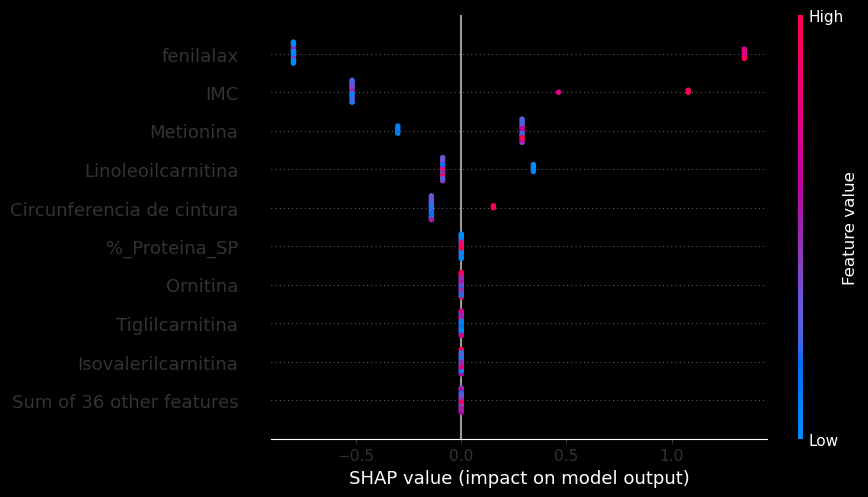

In [7]:
model_instance.get_AUC_on_test_data()
_, explainer_fitted, cohorts = model_instance.get_explainer_SHAP()

import shap

shap.plots.beeswarm(
    explainer_fitted,
    max_display=10,
    show=True,
)
